In [2]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.6 MB/s eta 0:00:00:00:0100:01


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
from numpy import mean
from numpy import std

In [2]:
casas = pd.read_csv("kc_house_data.csv")

casas.drop(['id'],axis=1,inplace=True)
casas.drop(['date'],axis=1,inplace=True)




In [18]:
casas['bedrooms'] = casas['bedrooms'].replace([33], int(casas[casas['price'] == 640000]['bedrooms'].mean()))

In [19]:
imputer = KNNImputer(n_neighbors=5)
casas[['sqft_basement', 'yr_renovated']] = imputer.fit_transform(casas[['sqft_basement', 'yr_renovated']])

In [43]:
def create_model(data, target, algo, scaler=None):
	if scaler != None:
		X = scaler.fit_transform(data)
	else:
		X = data
	y = target
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
	model = algo
	model.fit(X_train, y_train)
	return(model, X_train, X_test, y_train, y_test)

casas = casas.drop_duplicates()

condition = (casas['sqft_living'] > casas['sqft_lot']) & (casas['floors'] == 1)
for index, row in casas[condition].iterrows():
    casas.at[index, 'sqft_living'] = row['sqft_living15']
    casas.at[index, 'sqft_lot'] = row['sqft_lot15']

condition = (casas['sqft_living15'] > casas['sqft_lot15']) & (casas['floors'] == 1)
for index, row in casas[condition].iterrows():
    casas.at[index, 'sqft_living15'] = row['sqft_living']
    casas.at[index, 'sqft_lot15'] = row['sqft_lot']

scaler = MinMaxScaler()
casas['bedrooms'] = scaler.fit_transform(casas[['bedrooms']])
casas['grade'] = scaler.fit_transform(casas[['grade']])
casas['bathrooms'] = scaler.fit_transform(casas[['bathrooms']])
casas['floors'] = scaler.fit_transform(casas[['floors']])
casas['view'] = scaler.fit_transform(casas[['view']])
casas['sqft_above'] = scaler.fit_transform(casas[['sqft_above']])
casas['yr_built'] = scaler.fit_transform(casas[['yr_built']])
casas['sqft_living'] = scaler.fit_transform(casas[['sqft_living']])
casas['sqft_lot'] = scaler.fit_transform(casas[['sqft_lot']])
casas['sqft_living15'] = scaler.fit_transform(casas[['sqft_living15']])
casas['sqft_lot15'] = scaler.fit_transform(casas[['sqft_lot15']])
casas['condition'] = scaler.fit_transform(casas[['condition']])
casas['sqft_basement'] = scaler.fit_transform(casas[['sqft_basement']])
casas['yr_renovated'] = scaler.fit_transform(casas[['yr_renovated']])
casas['zipcode'] = scaler.fit_transform(casas[['zipcode']])
casas['lat'] = scaler.fit_transform(casas[['lat']])
casas['long'] = scaler.fit_transform(casas[['long']])

# Especificar colunas de features (X) e coluna alvo (y)
features = casas.drop("price", axis=1)  # Remova a coluna alvo "price" das features
target = casas["price"]

# Testando diversos regressores
#modelo, X_train, X_test, y_train, y_test = create_model(features, target, RandomForestRegressor(), scaler=None)
#modelo, X_train, X_test, y_train, y_test = create_model(features, target, LinearRegression(), scaler=None)
#modelo, X_train, X_test, y_train, y_test = create_model(features, target, SVR(), scaler=None)
#modelo, X_train, X_test, y_train, y_test = create_model(features, target, GradientBoostingRegressor(), scaler=None)
#modelo, X_train, X_test, y_train, y_test = create_model(features, target, KNeighborsRegressor(), scaler=None)
#modelo, X_train, X_test, y_train, y_test = create_model(features, target, Lasso(), scaler=None)
#modelo, X_train, X_test, y_train, y_test = create_model(features, target, Ridge(), scaler=None)
#modelo, X_train, X_test, y_train, y_test = create_model(features, target, ElasticNet(), scaler=None)
modelo, X_train, X_test, y_train, y_test = create_model(features, target, XGBRegressor(), scaler=None)

previsoes = modelo.predict(X_test)
mse = mean_squared_error(y_test, previsoes)
print(f'Mean Squared Error (MSE): {mse}')

y_pred = modelo.predict(X_test)
print(f'R2 (Test) : {r2_score(y_test, y_pred)}')
print(f'R2 (Training) : {r2_score(y_true=y_train, y_pred=modelo.predict(X_train))}')

Mean Squared Error (MSE): 16958734070.395502
R2 (Test) : 0.8728101493896889
R2 (Training) : 0.9791791118649712


Text(0, 0.5, 'Predicted prices')

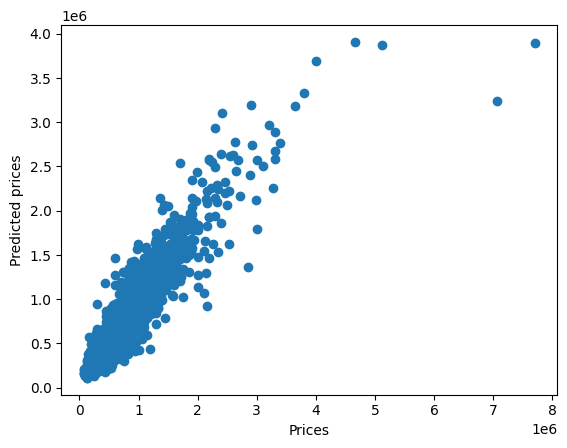

In [44]:
plt.scatter(y_test, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")

In [46]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score

lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
print("Root Mean Squared Error (Lasso): ", np.sqrt(-cross_val_score(lasso, features, target, cv=10, scoring='neg_mean_squared_error')).mean())

elastic = ElasticNet(alpha=0.001)
print("Root Mean Squared Error (ElasticNet): ", np.sqrt(-cross_val_score(lasso, features, target,  cv=10, scoring='neg_mean_squared_error')).mean())

ridge = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
print("Root Mean Squared Error (Ridge): ", np.sqrt(-cross_val_score(lasso, features, target,  cv=10, scoring='neg_mean_squared_error')).mean())

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3349244551588.9375, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172545874940975.62, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267576623415083.75, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_

Root Mean Squared Error (Lasso):  201951.37386332857


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3349244551588.9375, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172545874940975.62, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267576623415083.75, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_

Root Mean Squared Error (ElasticNet):  201951.37386332857


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3349244551588.9375, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172545874940975.62, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267576623415083.75, tolerance: 204936104224.535
  model = cd_fast.enet_coordinate_descent_gram(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_

Root Mean Squared Error (Ridge):  201951.37386332857


In [30]:
lasso = Lasso(alpha=0.01).fit(X_train, y_train)
print("Lasso Regression-Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Lasso Regression-Test set score: {:.2f}".format(lasso.score(X_test, y_test)))

Lasso Regression-Training set score: 0.70
Lasso Regression-Test set score: 0.70


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e+14, tolerance: 1.962e+11
  model = cd_fast.enet_coordinate_descent(


In [33]:
print(f"Number of features: {sum(lasso.coef_ != 0)}")

Number of features: 18


/home/codespace/.python/current/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [16:14:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (Xgboost):  124205.39394976129
R2 (Test) : 0.8842982466172813
R2 (Training) : 0.9791791118649712


Text(0.5, 1.0, 'xgboost')

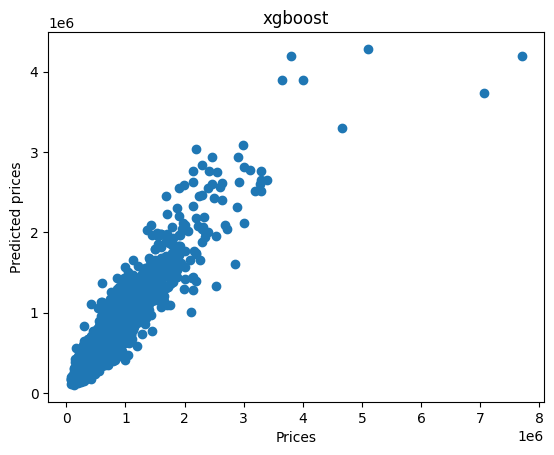

In [27]:
from sklearn import metrics 
regr = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1.5, n_estimators=7200, reg_alpha=0.9, reg_lambda=0.6, subsample=0.2, seed=42, silent=1)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Root Mean Squared Error (Xgboost): ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(f'R2 (Teste) : {r2_score(y_test, y_pred)}')
print(f'R2 (Treinamento) : {r2_score(y_true=y_train, y_pred=modelo.predict(X_train))}')

plt.scatter(y_test, y_pred)
plt.xlabel("Precos")
plt.ylabel("Predicão")
plt.title("xgboost")





In [10]:
pred = pd.DataFrame({'Atual': y_test, 'Predição': y_pred})
pred.head()

,Atual,Predição
15075,690000.0,597995.187500
9685,430000.0,486080.687500
10424,109000.0,184971.046875
19015,581000.0,638945.437500
19154,650000.0,531618.750000
